In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Mask-Or-No-Mask'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

In [59]:
import os
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter


In [60]:

# Path to images and labels
DATASET_PATH = "../CW_Dataset"
TRAIN_IMAGE_PATH = "../CW_Dataset/train/images"
TRAIN_LABEL_PATH = "../CW_Dataset/train/labels"
TEST_IMAGE_PATH = "../CW_Dataset/test/images"
TEST_LABEL_PATH = "../CW_Dataset/test/labels"
SAVE_DIR = "../npy_dataset"

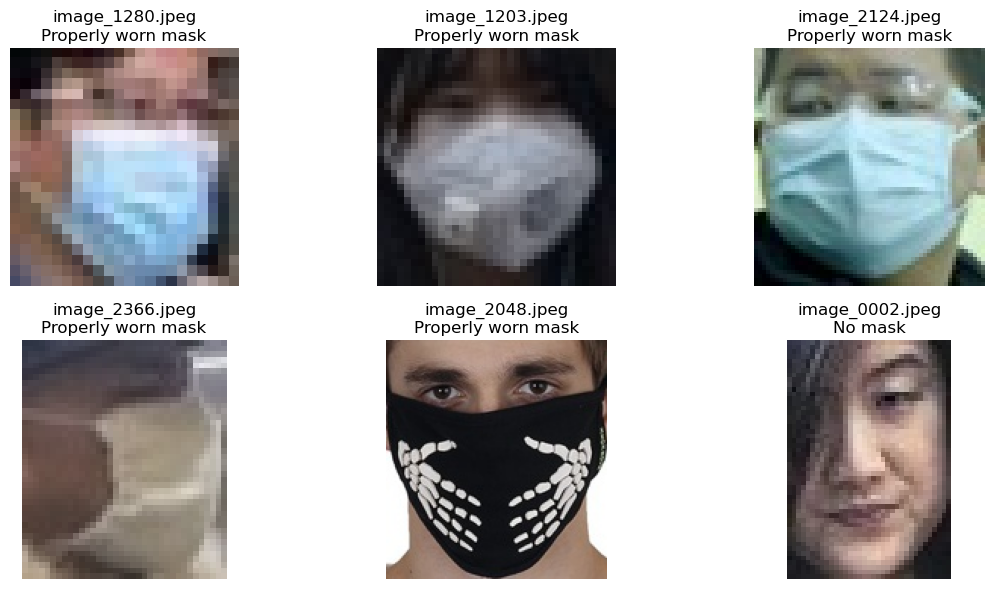

In [61]:
def show_random_images(ip, lp):
    # Map to associate value with category
    label_map = {
        '0': "No mask",
        '1': "Properly worn mask",
        '2': "Improperly worn mask"
    }

    # Get all images
    image_files = [f for f in os.listdir(ip) if f.lower().endswith('.jpeg')]

    # Select random images
    num_samples = 6
    sampled_images = random.sample(image_files, num_samples)

    # Plot
    plt.figure(figsize=(12, 6))
    for i, img_name in enumerate(sampled_images):
        img_path = os.path.join(ip, img_name)

        # Read image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert to RGB for matplotlib

        # Find label for image
        label_filename = os.path.splitext(img_name)[0] + '.txt'
        label_path = os.path.join(lp, label_filename)

        # Read label
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label_index = f.read().strip()
            label_text = label_map.get(label_index, "Unknown label")
        else:
            label_text = 'Unknown label'

        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.title(f"{img_name}\n{label_text}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_random_images(TRAIN_IMAGE_PATH, TRAIN_LABEL_PATH)

- Initially thought of using padding to make all images the same size
- Realised this might cause issues with edge detection, because of the sharp border of the black/white pixels I will be adding
	- This could cause big issues down the line with feature descriptors
- Thought about adding padding then using a pre-trained face detection model to crop into the faces and pull a consistent size
- Realised, if I'm using face detection, then why bother adding padding as the face detection should only pull the face regardless of image size.
- Options
	- OpenCV Haar Cascade Classifier
	- OpenCV DNN Face Detection
	- dlib.get_frontal_face()
- Decided on using OpenCVs DNN Face Detection model
- Learnt that that model needs images of at least 100x100 to be nicely accurate
- Realised, that due to the vast different in the sizes of the images even if the image size wasn't an issue, the face detection model would probably poorly handle up/downscaling of the images

- Going to write code to allow me to find the frequency of the sizes of the images and visualise them, that way I can choose the best size to normalise too. I.e.
	- Most images are in the range 10x10 - 70x70 then 64x64 seems fitting
	- Most images are in the range 100x100 - 150x150 then 128x128 seems fitting

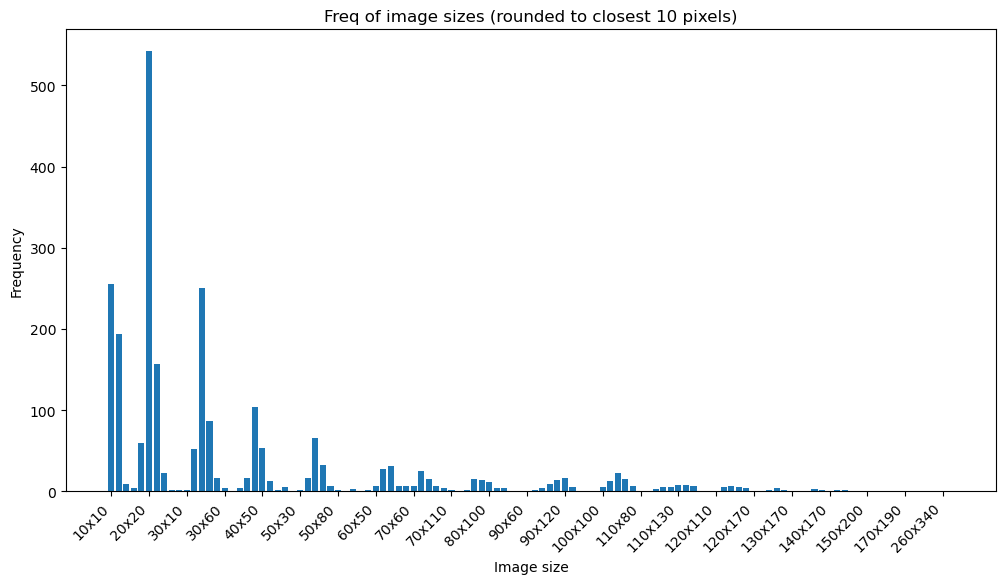

In [62]:
image_sizes = []

for filename in os.listdir(TRAIN_IMAGE_PATH):
    if filename.lower().endswith('.jpeg'):
        img_path = os.path.join(TRAIN_IMAGE_PATH, filename)
        img = cv2.imread(img_path)

        if img is not None:
            h, w = img.shape[:2]
            rounded_sizes = (w // 10 * 10, h // 10 * 10)
            image_sizes.append(rounded_sizes)

counter = Counter(image_sizes)

sorted_sizes = sorted(counter.items(), key=lambda x: (x[0][0], x[0][1]))
labels = [f"{w}x{h}" for (w, h), _ in sorted_sizes]
counts = [count for _, count in sorted_sizes]

skip = 5

plt.figure(figsize=(12, 6))
plt.bar(labels, counts)
plt.xticks(ticks = range(0, len(labels), skip), labels = labels[::skip], rotation = 45, ha = 'right')
plt.title('Freq of image sizes (rounded to closest 10 pixels)')
plt.xlabel('Image size')
plt.ylabel('Frequency')
#plt.tight_layout()
plt.show()


- Based on the results from the visualisation I can see that most of the images are on the smaller side therefore I will go 64x64.
	- I questioned whether I should choose a rectangular size rather than square but upon research learned that
	    - 64x64 is somewhat of a standard
	    - It is best for model compatibility
	    - Allows for uniform cell layout for HOG descriptors
	    - can easily augment the image (flip/rotate)
	    - etc.

- Adding padding to the image
    - Maintaining aspect ratio
    - Centering image
    - Padding colour will be black

In [63]:
def resize_with_padding(img, target_size=(64, 64), pad_colour=0):
    # Get image height and width
    h, w = img.shape[:2]
    # Target height and width
    th, tw = target_size

    # Set interpolation function based downscaling or upscaling
    interpolation = cv2.INTER_AREA if h > th or w > tw else cv2.INTER_CUBIC

    # Calculate aspect ratio of input image and maintain it for maintaining that aspect ratio
    aspect_ratio = float(h) / float(w)
    if aspect_ratio > 1:
        new_w = tw
        new_h = int(new_w / aspect_ratio)
    else:
        new_h = th
        new_w = int(new_h * aspect_ratio)

    # Resize the image
    resized_img = cv2.resize(img, (new_w, new_h), interpolation=interpolation)

    # Calculate amount of padding needed, and keeping image centered
    pad_top = (th - new_h) // 2
    pad_bottom = th - new_h - pad_top
    pad_left = (tw - new_w) // 2
    pad_right = tw - new_w - pad_left

    # Add the padding (chosen colour is black)
    padded_image = cv2.copyMakeBorder(resized_img, pad_top, pad_bottom, pad_left, pad_right, borderType = cv2.BORDER_CONSTANT, value = pad_colour)

    return padded_image

- Loading normalized images
    - Make images greyscale
    - Normalize pixel values
    - Save all the images as np.array so I don't have to do this every time
    - Add the images and labels to lists for ease of use

In [68]:
def load_normalize_images(set_type="train"):
    # Choose paths based on train or test data
    if set_type == "train":
        image_dir = TRAIN_IMAGE_PATH
        label_dir = TRAIN_LABEL_PATH
        save_name_suffix = "train"
    elif set_type == "test":
        image_dir = TEST_IMAGE_PATH
        label_dir = TEST_LABEL_PATH
        save_name_suffix = "test"
    else:
        raise ValueError("set_type must be 'train' or 'test'")

    # List to store images and labels
    X = []
    y = []

    # Iterate through all the images in the target dir
    for img_file in os.listdir(image_dir):
        if not img_file.lower().endswith('.jpeg'):
            continue

        # Make paths to each image and label
        img_path = os.path.join(image_dir, img_file)
        label_file = os.path.splitext(img_file)[0] + '.txt'
        label_path = os.path.join(label_dir, label_file)

        # Make image greyscale
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Skip if error with image
        if img is None or not os.path.exists(label_path):
            continue

        # Get the label that matches the image
        with open(label_path, 'r') as f:
            label_string = f.read().strip()

        # Skip if the labels are not valid
        if label_string not in ['0', '1', '2']:
            continue

        # Convert label to int for ease of use later
        label = int(label_string)

        # Resize image with padding if necessary
        normalized_img = resize_with_padding(img)

        # Normalize pixel values
        normalized_img = normalized_img.astype(np.float32) / 255.0

        # Add normalized image to list
        X.append(normalized_img)
        y.append(label)

    # Create numpy arrays
    X = np.array(X)
    y = np.array(y)

    # Save the files as .npy
    np.save(os.path.join(SAVE_DIR, f'X_{save_name_suffix}.npy'), X)
    np.save(os.path.join(SAVE_DIR, f'y_{save_name_suffix}.npy'), y)

    return X, y

- Visualise the normalised images to make sure it all looks good
- I want the images to be saved as 2D arrays so I'll remove the singleton channel as well (if there is one present)

In [65]:

def show_random_normalized_images(X, y, label_map = None, num_samples = 6, dataset_name="Dataset"):
    # Match the labels with the correct categories
    if label_map is None:
        label_map = {
            0: "No mask",
            1: "Properly worn mask",
            2: "Improperly worn mask"
        }

    # Randomly select the images from the dataset (I don't want over 2000 images all being shown haha)
    indices = random.sample(range(len(X)), num_samples)

    # Create the grid to display images
    plt.figure(figsize=(12, 6))

    # Add title so I know what dataset is being used
    plt.suptitle(f'Random samples from {dataset_name}', fontsize=20)

    # Plot image with label
    for i, idx in enumerate(indices):
        img = X[idx]
        label = y[idx]
        label_text = label_map.get(label, "Unknown")

        # Remove singleton channel
        if img.ndim == 3 and img.shape[-1] == 1:
            img = img.squeeze()

        # Create the plot
        plt.subplot(2, 3, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(label_text)
        plt.axis('off')

    # Display
    plt.tight_layout(rect=(0.0, 0.0, 1.0, 1.0))
    plt.show()

Train images: 2394
Test images: 458


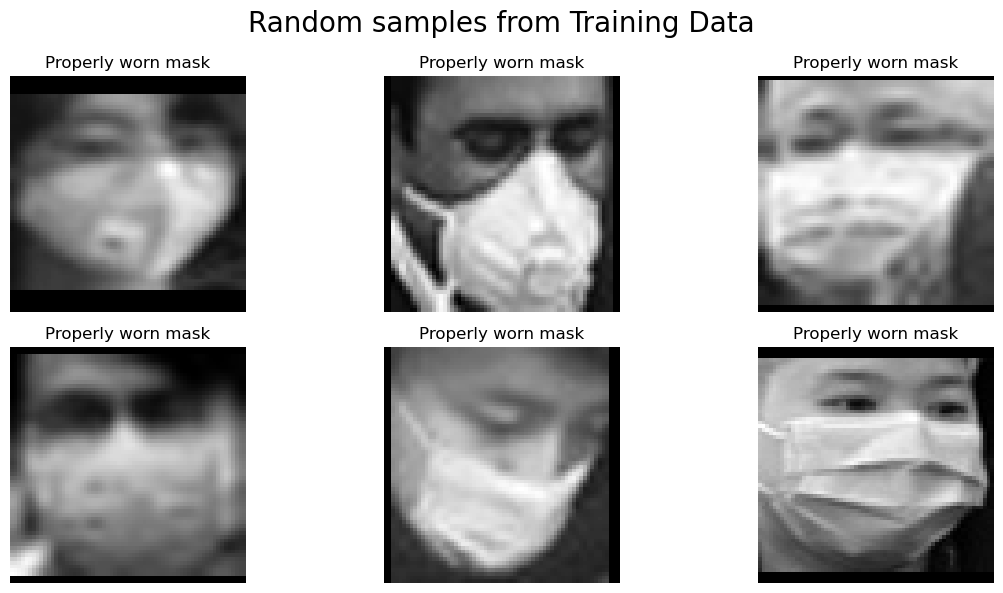

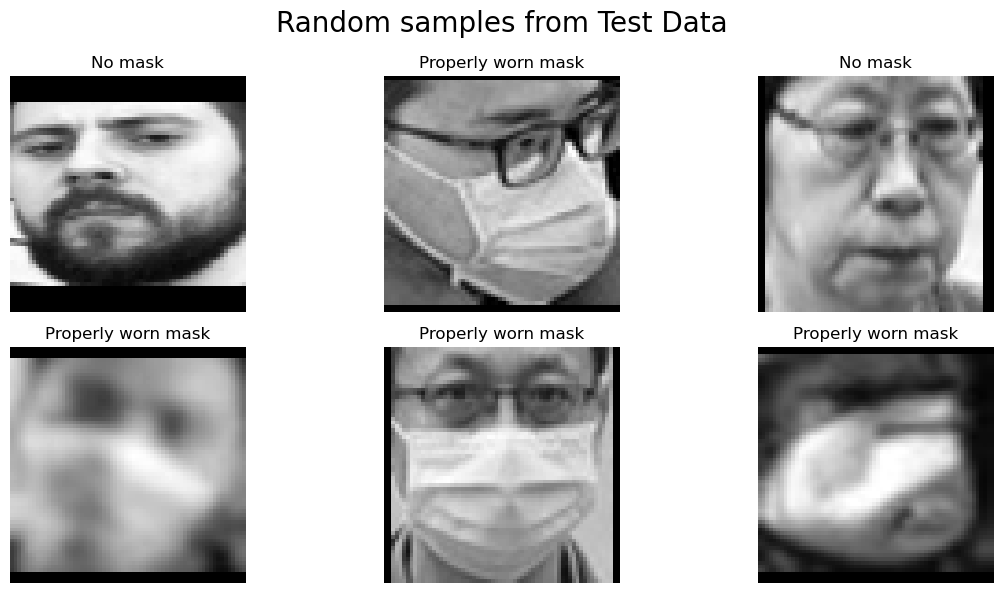

In [69]:
X_train, y_train = load_normalize_images("train")
X_test, y_test = load_normalize_images("test")


print("Train images:", len(X_train))
print("Test images:", len(X_test))

show_random_normalized_images(X_train, y_train, dataset_name = "Training Data")
show_random_normalized_images(X_test, y_test, dataset_name = "Test Data")
